# UNet, DeepLabv3 (mobileNet backbone), SegFormer

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "/home/m_evgeniy/BOSK")

from bosk.imports import *
from bosk.utils import *
from bosk.train import *

## Загрузка датасета

In [2]:
from pathlib import Path

# Setup path to data folder
data_path = Path("../data/Dataset_VALID")

# If the image folder doesn't exist, download it and prepare it...
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory :(")

../data/Dataset_VALID directory exists.


## Создаем необходимые папки для тренировки

In [3]:
# Setup train and testing paths
train_dir = data_path / "train"
val_dir = data_path / "valid"
test_dir = data_path / "test"

train_dir, val_dir, test_dir

(PosixPath('../data/Dataset_VALID/train'),
 PosixPath('../data/Dataset_VALID/valid'),
 PosixPath('../data/Dataset_VALID/test'))

In [ ]:
def create_dirs(root_dir):
    """
    Создает директорию с подпапками 'images' и 'masks'

    Input:
    - root_dir - директория, которую еобходимо обработать

    Return:
    - nothing
    """

    images_dir = root_dir / "images"
    masks_dir = root_dir / "masks"
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)

create_dirs(train_dir)
create_dirs(val_dir)
create_dirs(test_dir)

### Для разделения датасета на train, test и validation

In [ ]:
# remove_identifier_files(data_path)
# split_dataset(data_path)

Разделение завершено.


In [5]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images / masks in '{dirpath}'.")


walk_through_dir(data_path)

There are 3 directories and 0 images / masks in '../data/Dataset_VALID'.
There are 2 directories and 0 images / masks in '../data/Dataset_VALID/test'.
There are 0 directories and 129 images / masks in '../data/Dataset_VALID/test/masks'.
There are 0 directories and 129 images / masks in '../data/Dataset_VALID/test/images'.
There are 2 directories and 0 images / masks in '../data/Dataset_VALID/valid'.
There are 0 directories and 66 images / masks in '../data/Dataset_VALID/valid/masks'.
There are 0 directories and 66 images / masks in '../data/Dataset_VALID/valid/images'.
There are 2 directories and 0 images / masks in '../data/Dataset_VALID/train'.
There are 0 directories and 453 images / masks in '../data/Dataset_VALID/train/masks'.
There are 0 directories and 453 images / masks in '../data/Dataset_VALID/train/images'.


## VALID dataset testing

In [ ]:
mask_path = "../data/Dataset_VALID/train/masks/img_1_5_1552036411134277400.png"  # путь к одной из масок
get_unique_classes(mask_path)

Уникальные классы в маске: [ 39  77 106 110 152 153 180]
Количество классов: 7


## Здесь выбираем какую модель будем использовать для тренировки

### Выбираем SegFormer-B0

In [7]:
transform = None
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,  # Меняем количество выходных классов
    ignore_mismatched_sizes=True  # Позволяет менять последний слой
).to(device)

model.decode_head.classifier = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
torch.nn.init.xavier_uniform_(model.decode_head.classifier.weight)
torch.nn.init.zeros_(model.decode_head.classifier.bias)

model_type = "segformer"

/home/m_evgeniy/BOSK/venv/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Выбираем Deeplab_v3

In [61]:
processor = None
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

model = deeplabv3_mobilenet_v3_large()
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

model_type = "deeplab"

### Unet + mobile_net_v2

In [ ]:
model = smp.Unet(
    encoder_name="mobilenet_v2",  # Легкий бэкбон
    encoder_weights="imagenet",   # Предобученные веса
    classes=NUM_CLASSES,          # Количество классов
).to(device)

processor = None
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

model_type = "unet"

### Unet + EfficenceNet-B4

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b4",  
    encoder_weights="imagenet",  
    in_channels=3,  
    classes=NUM_CLASSES
).to(DEVICE)

processor = None
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

model_type = "unet"

### Смотрим параметры модели

In [8]:
summary(model=model,
        input_size=(1, 3, 512, 512),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
SegformerForSemanticSegmentation (SegformerForSemanticSegmentation)         [1, 3, 512, 512]     [1, 5, 128, 128]     --                   True
├─SegformerModel (segformer)                                                [1, 3, 512, 512]     [1, 32, 128, 128]    --                   True
│    └─SegformerEncoder (encoder)                                           [1, 3, 512, 512]     [1, 32, 128, 128]    --                   True
│    │    └─ModuleList (patch_embeddings)                                   --                   --                   (recursive)          True
│    │    └─ModuleList (block)                                              --                   --                   (recursive)          True
│    │    └─ModuleList (layer_norm)                                         --                   --                   (recursive)  

## Создаем датасет

In [9]:
train_data = VALID_Dataset(root_dir=train_dir, model_type=model_type,
                           transforms=transform, processor=processor)

test_data = VALID_Dataset(root_dir=test_dir, model_type=model_type,
                          transforms=transform, processor=processor)

val_data = VALID_Dataset(root_dir=val_dir, model_type=model_type,
                      transforms=transform, processor=processor)

In [10]:
batch_size = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size, # how many samples per batch?
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                             batch_size=batch_size,
                             shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(57, 17)

In [11]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3986644..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9705454..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8506721..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95342064..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69654936..2.4482791].


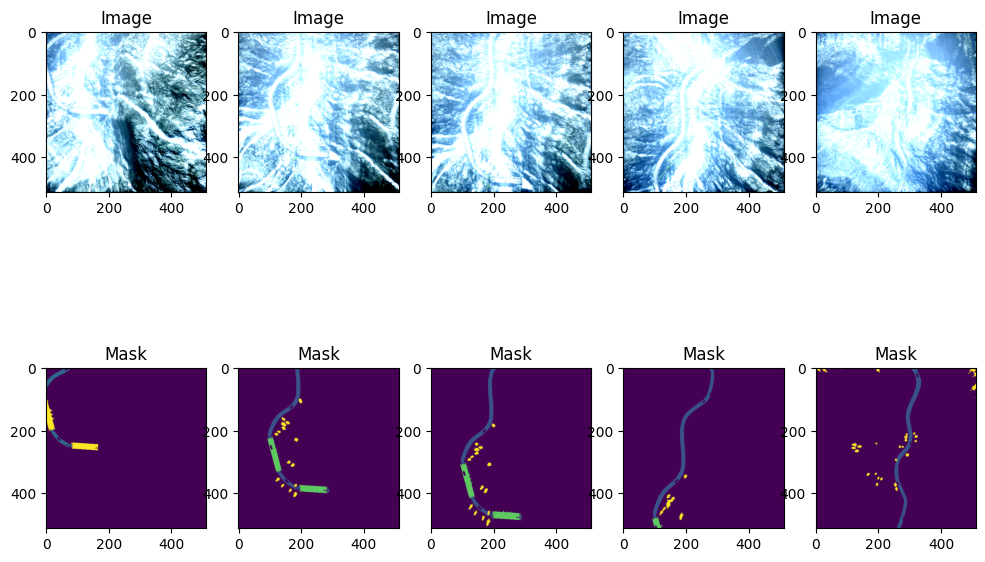

In [13]:
data = next(iter(test_dataloader))
num_examples = 5

fig, axes = plt.subplots(2, num_examples, figsize=(12, 8))

images, masks = data
for i in range(num_examples):
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].set_title("Image")
    axes[1, i].imshow(masks[i])
    axes[1, i].set_title("Mask")


In [ ]:
from torchmetrics import JaccardIndex

epochs = 2
lr = 1e-3

# Запускаем обучение
model_save_name = "segformer_3"
assert model_save_name is not None, "Enter model's name for saving"

criterion = nn.CrossEntropyLoss()
best_model, loss_history, iou_score_history, dice_score_history = train(model, train_dataloader, val_dataloader, criterion, lr, epochs, model_type, verbose=True, is_scheduler=False)

# --- 6. Сохранение модели ---
torch.save(best_model.state_dict(), f"../models/{model_save_name}.pth")
print("Модель сохранена!")

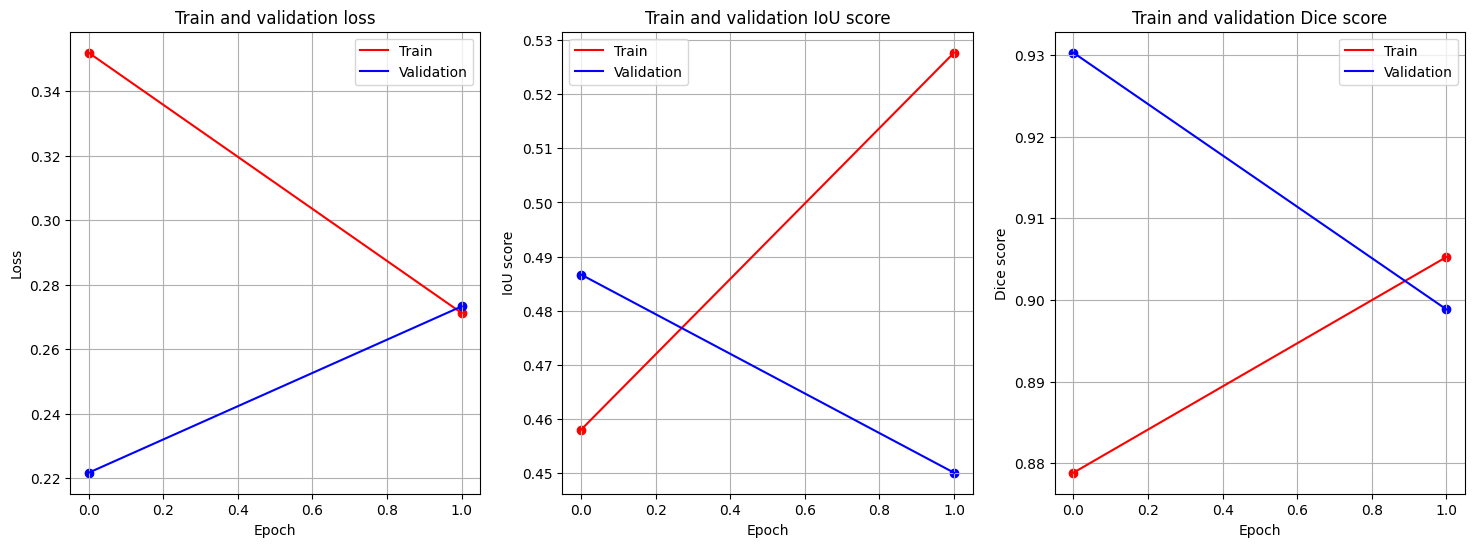

In [22]:
def visualize_losses_and_scores(losses, iou_scores, dice_scores):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    epochs = np.arange(len(losses["train"]))

    # Лоссы
    axes[0].plot(epochs, losses["train"], c="r", label="Train")
    axes[0].scatter(epochs, losses["train"], c="r")
    axes[0].plot(epochs, losses["valid"], c="b", label="Validation")
    axes[0].scatter(epochs, losses["valid"], c="b")
    axes[0].set_title("Train and validation loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid()

    # IoU Score (переводим тензоры в CPU и numpy)
    train_scores = [s.cpu().item() if isinstance(s, torch.Tensor) else s for s in iou_scores["train"]]
    valid_scores = [s.cpu().item() if isinstance(s, torch.Tensor) else s for s in iou_scores["valid"]]

    axes[1].plot(epochs, train_scores, c="r", label="Train")
    axes[1].scatter(epochs, train_scores, c="r")
    axes[1].plot(epochs, valid_scores, c="b", label="Validation")
    axes[1].scatter(epochs, valid_scores, c="b")
    axes[1].set_title("Train and validation IoU score")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("IoU score")
    axes[1].legend()
    axes[1].grid()

    train_scores = [s.cpu().item() if isinstance(s, torch.Tensor) else s for s in dice_scores["train"]]
    valid_scores = [s.cpu().item() if isinstance(s, torch.Tensor) else s for s in dice_scores["valid"]]

    axes[2].plot(epochs, train_scores, c="r", label="Train")
    axes[2].scatter(epochs, train_scores, c="r")
    axes[2].plot(epochs, valid_scores, c="b", label="Validation")
    axes[2].scatter(epochs, valid_scores, c="b")
    axes[2].set_title("Train and validation Dice score")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Dice score")
    axes[2].legend()
    axes[2].grid()

    plt.show()

visualize_losses_and_scores(loss_history, iou_score_history, dice_score_history)


Loss =  tensor(0.2429)
IoU score =  tensor(0.5150)
Dice score =  tensor(0.9152)


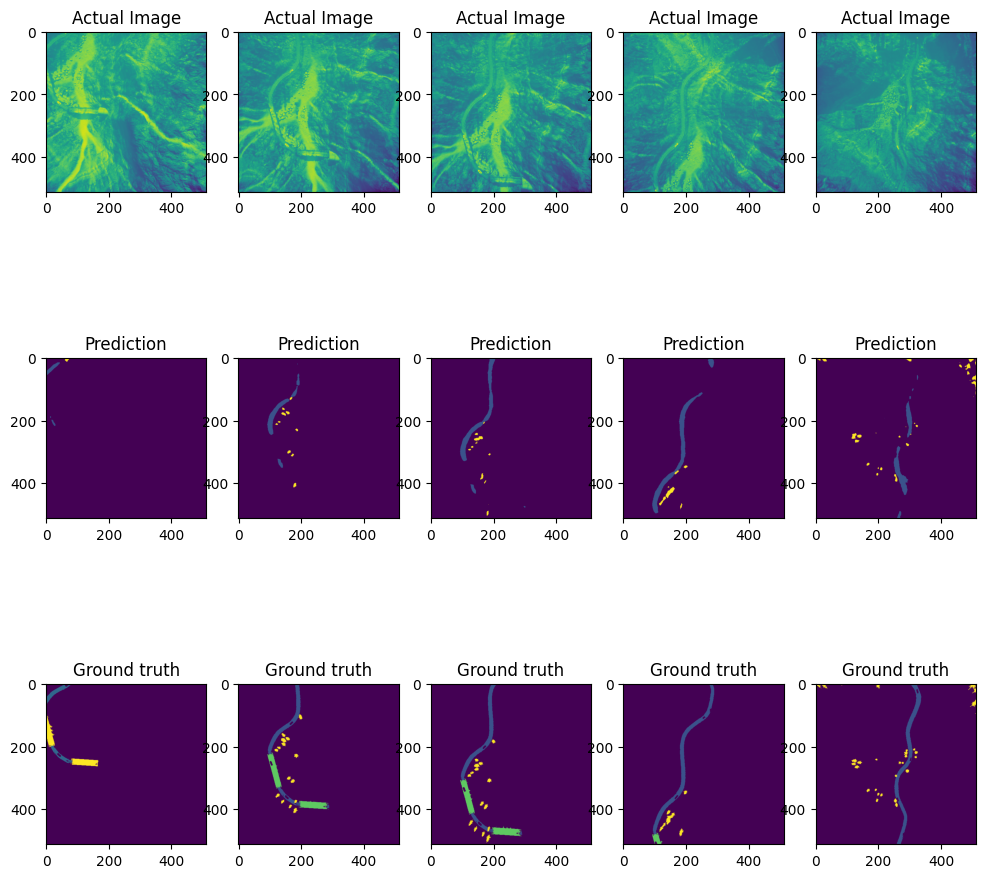

In [23]:
data_images, prediction_masks, ground_truth_masks = testing_model(model, test_dataloader, model_type, visualization=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


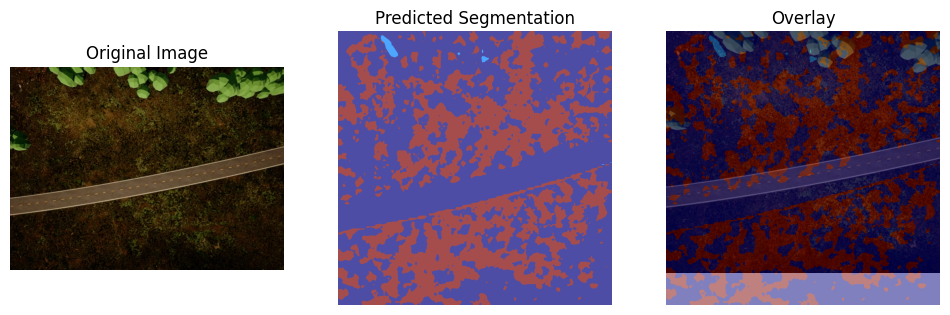

In [30]:
# === Функция предсказания и визуализации ===
def predict_and_visualize(model, data_path, model_name, device=DEVICE):
    # Преобразования
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
    ])

    # Загружаем изображение
    image = Image.open(data_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Предсказание
    with torch.no_grad():
        output = make_prediction(model, input_tensor, model_name)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # === Визуализация ===
    plt.figure(figsize=(12, 5))

    # Оригинальное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")

    # Предсказанная маска
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.7)
    plt.axis("off")
    plt.title("Predicted Segmentation")

    # Наложение маски на изображение
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay")

    plt.show()


# === Функция для загрузки модели ===
def load_deeplab_model(model_path, num_classes=5, device=DEVICE):
    model = deeplabv3_mobilenet_v3_large()  # Загружаем архитектуру
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)  # Заменяем последний слой
    model.load_state_dict(torch.load(model_path, map_location=device))  # Загружаем веса
    model.to(device).eval()
    return model

def load_segformer_model(model_path, num_classes=5, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=num_classes,  # Меняем количество выходных классов
        ignore_mismatched_sizes=True  # Позволяет менять последний слой
    )

    model.decode_head.classifier = nn.Conv2d(256, num_classes, kernel_size=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    return model

def load_unet_mobile_model(model_path, num_classes=5, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = smp.Unet(
        encoder_name="mobilenet_v2",  # Легкий бэкбон
        encoder_weights="imagenet",   # Предобученные веса
        classes=num_classes,          # Количество классов
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))  # Загружаем веса
    model.to(device).eval()
    return model

def load_unet_efficient_model(model_path, num_classes=5, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = smp.Unet(
        encoder_name="efficientnet-b4",  # Легкий бэкбон
        encoder_weights="imagenet",   # Предобученные веса
        classes=num_classes,          # Количество классов
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))  # Загружаем веса
    model.to(device).eval()
    return model


# === Использование ===
model_path = "../models/segformer_3.pth"  # Путь к модели
model_type = "segformer"
model = load_model(model_path, model_type)
data_path = "../Some_images/image.png"  # Путь к изображению для предсказания
predict_and_visualize(model, data_path, model_type)


In [31]:
import time

def infer_time(net, path='./map.png', dev='cuda'):
  img = Image.open(path).convert("RGB")
  if transform:
      trf = transform
      inp = trf(img).unsqueeze(0).to(dev)
  if processor:
      encoding = processor(img, return_tensors="pt")
      inp = encoding["pixel_values"].to(dev)
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()

  return et - st

time_cuda = infer_time(model, '../Some_images/map.png', dev="cuda")
time_cpu = infer_time(model, '../Some_images/map.png', dev="cpu")
print("Time on cpu = ", time_cpu)
print("Time on cuda = ", time_cuda)

Time on cpu =  1.1128838062286377
Time on cuda =  0.047983646392822266
